# HOMEWORK 14 FOR LECTURE 15

In this homework we will be working with the Fashion MNIST dataset. You will be given a classifier which suffers from considerable overfitting. Your objective will be to employ regularization techniques to mitigate the overfitting problem.

Let's start with the usual imports.

In [34]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras import Model
from time import time
from tensorflow.keras.utils import plot_model
from IPython.display import Image

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

### Dataset

The MNIST fashgion dataset [link](https://github.com/zalandoresearch/fashion-mnist) was build by Zalando Reasearch tem consists of monochrome images of different type of clothing, namely:
* 0	T-shirt/top
* 1	Trouser
* 2	Pullover
* 3	Dress
* 4	Coat
* 5	Sandal
* 6	Shirt
* 7	Sneaker
* 8	Bag
* 9	Ankle boot

It is also one of the Keras built-in datasets. Let's load the images and quickly inspect it.

In [2]:
labels_str = """0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot"""
labels = [lb[2:] for lb in labels_str.split('\n')]
print(labels)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Dataset params
num_classes = 10
size1, size2 = x_train.shape[1], x_train.shape[2]

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    60000 samples
Test set:     10000 samples
Sample dims:  (60000, 28, 28)


Let's visualise some random samples.

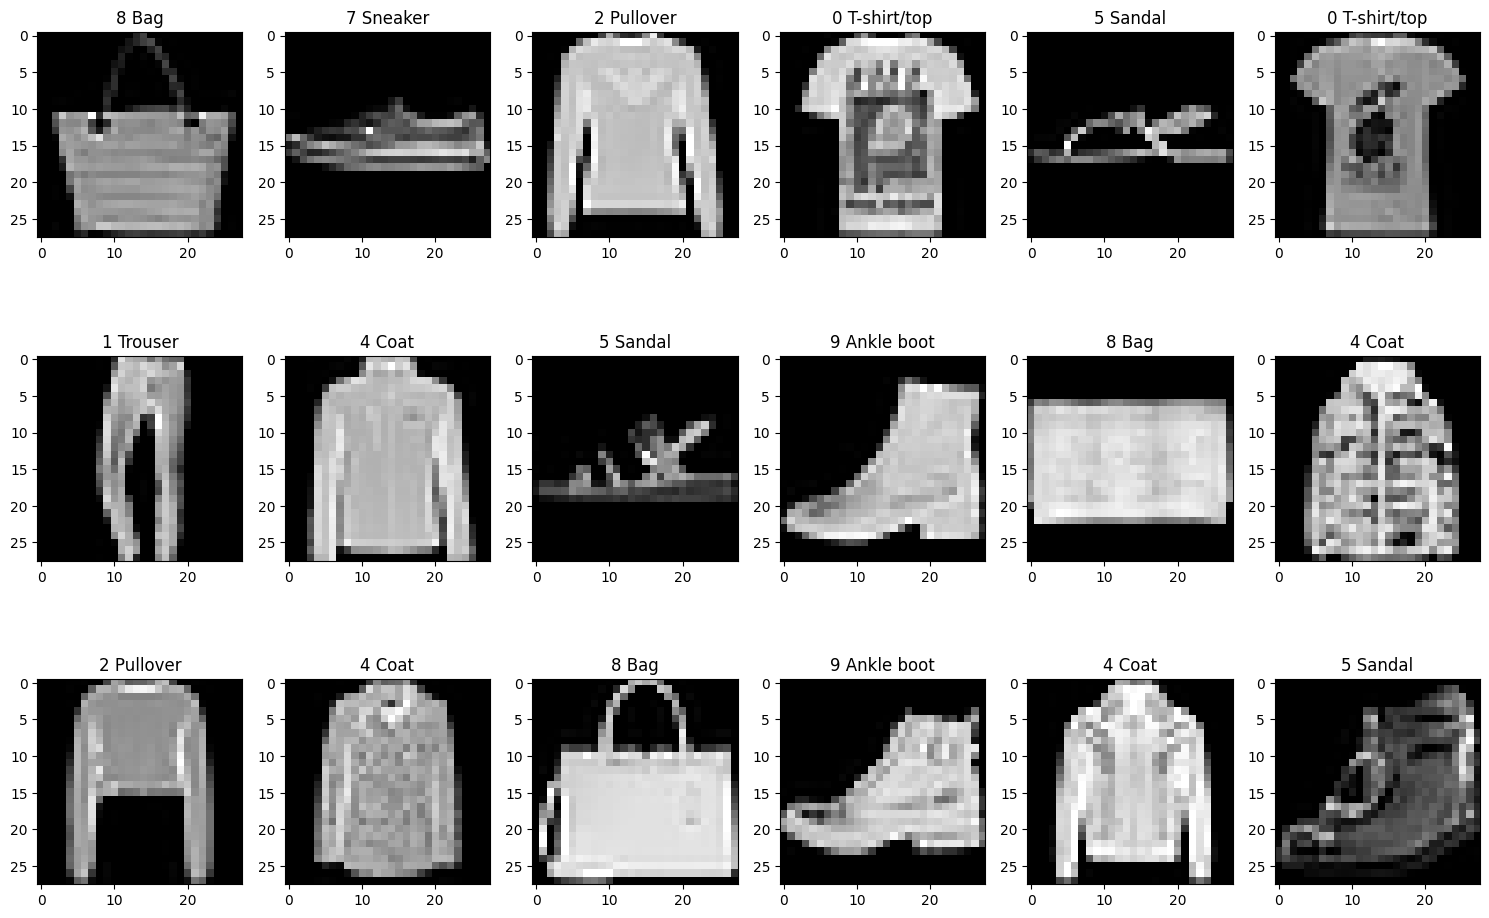

In [4]:
def plot_image_table(x_train, y_train, rows=3, cols=6):
    cnt = 1
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(x_train))
            plt.subplot(rows, cols, cnt)
            plt.imshow(x_train[idx, ...], cmap='gray')
            plt.title(f"{y_train[idx]} {labels[y_train[idx]]}")
            cnt += 1
    plt.tight_layout()
    plt.show()

plot_image_table(x_train, y_train)

### Building the Classifier

We are now going to build the baseline classifier that you will use throughout this homework.

In [5]:
# Data normalization
x_train = x_train/255
x_test = x_test/255

In [6]:
def create_model(*layers):
    inputs = net = layers[0]    
    for l in layers[1:]:
        net = l(net)
    model = Model(inputs,net)
    return model

def show_model(model):
    model.summary()
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return Image('model_plot.png',width=600)
    

model = create_model(
    Input(shape=(28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    Flatten(),
    Dense(128),
    Dense(10, activation="softmax")
)

I0000 00:00:1722243591.995848    1006 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722243593.276148    1006 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722243593.276235    1006 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722243593.304339    1006 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722243593.304502    1006 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,213,002 (12.26 MB)

 Trainable params: 3,213,002 (12.26 MB)

 Non-trainable params: 0 (0.00 B)

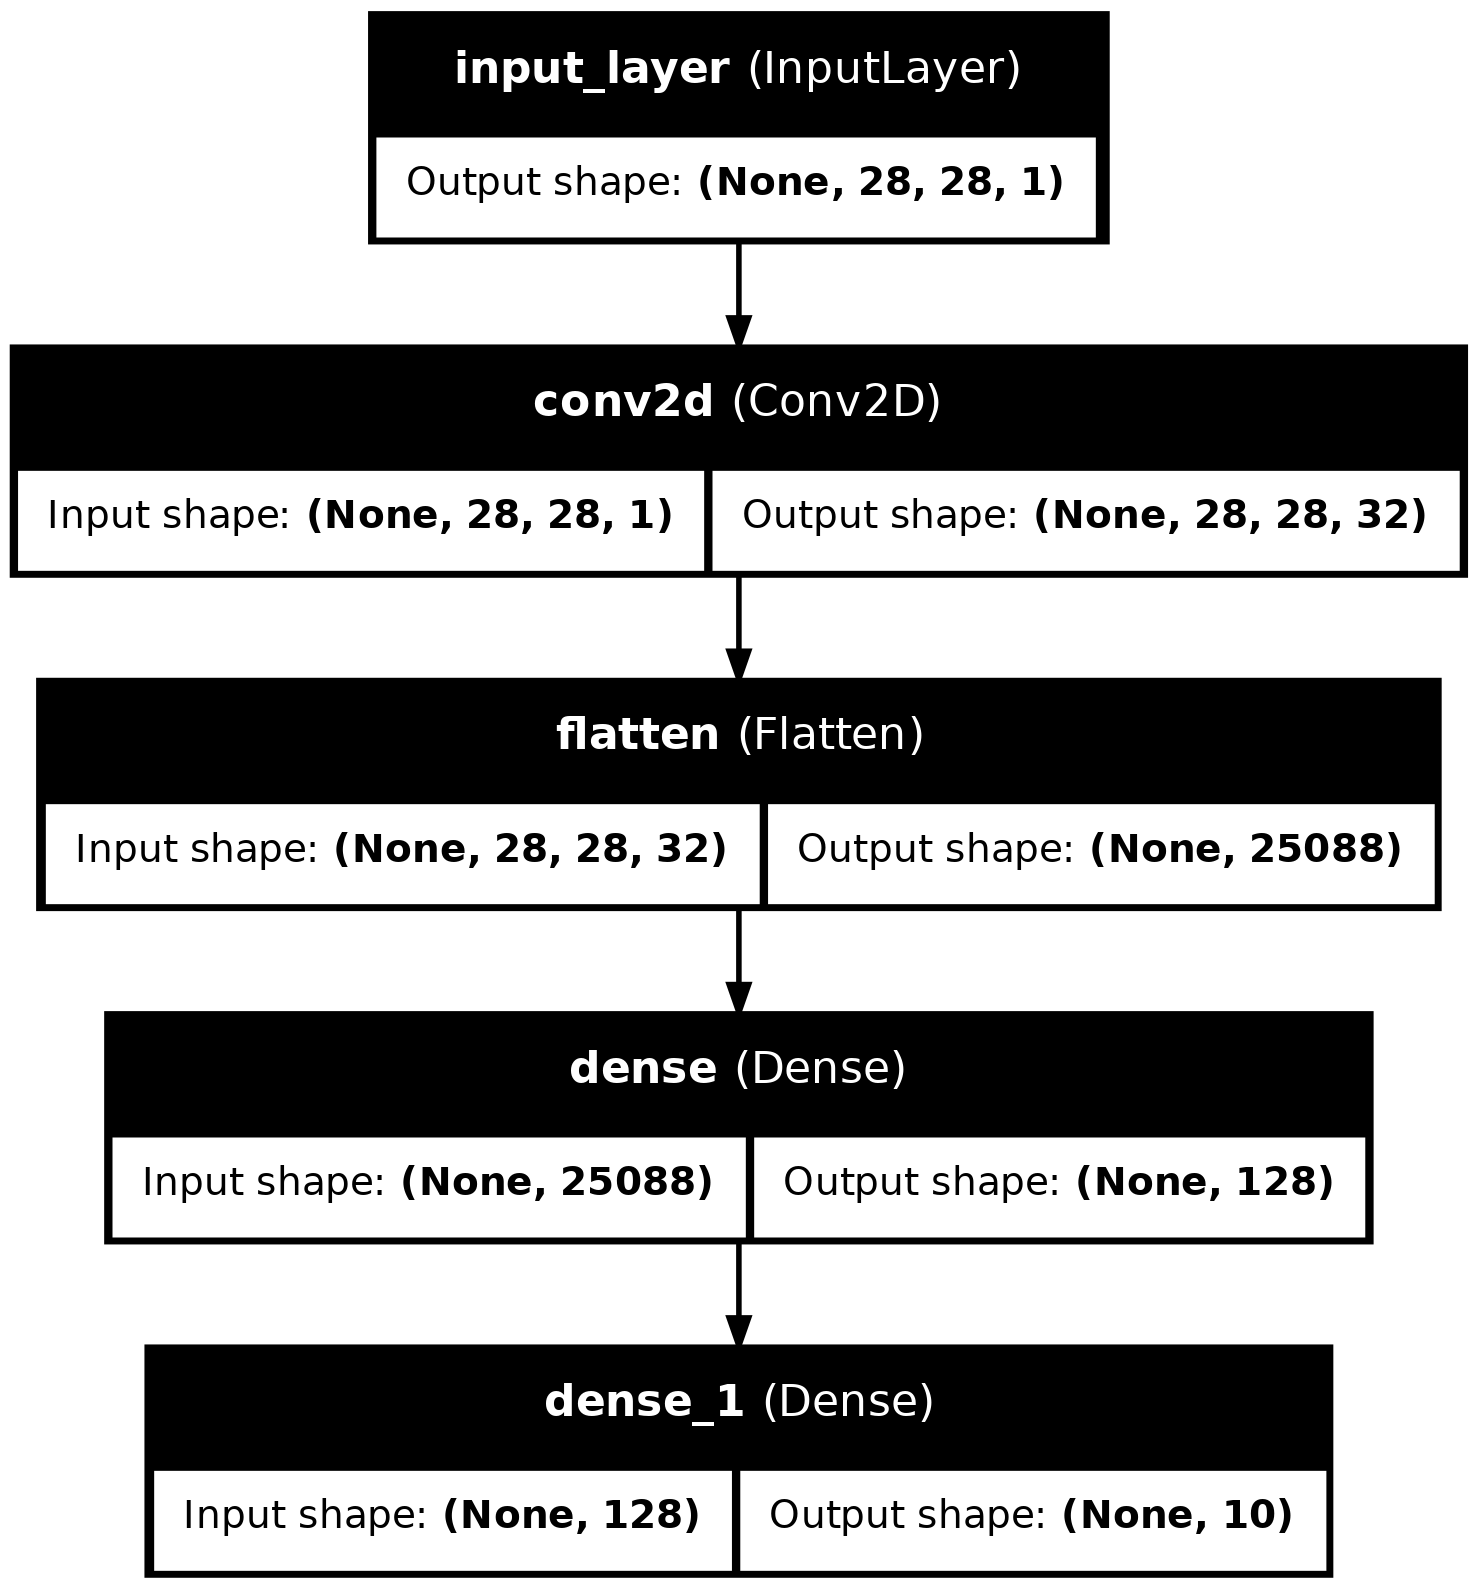

In [7]:
show_model(model)

In [7]:
epochs = 50
batch_size = 64

def fit_model(model, validation_split=0.1):    
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    start = time()
    h = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), validation_split=validation_split)
    print('Elapsed time', time() - start)
    return h

def fit_model_generator(model, generator, validation_split=0.1):    
    steps_per_epoch = len(y_train) // batch_size
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    start = time()
    h = model.fit(generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=(x_test, y_test), validation_split=validation_split)
    print('Elapsed time', time() - start)
    return h

In [19]:
history = fit_model(model)

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9617 - loss: 0.1036 - val_accuracy: 0.8940 - val_loss: 0.3985
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9646 - loss: 0.0959 - val_accuracy: 0.9107 - val_loss: 0.3227
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9680 - loss: 0.0877 - val_accuracy: 0.8886 - val_loss: 0.4804
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9657 - loss: 0.0886 - val_accuracy: 0.8795 - val_loss: 0.5443
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9678 - loss: 0.0864 - val_accuracy: 0.9027 - val_loss: 0.3839
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9712 - loss: 0.0775 - val_accuracy: 0.8900 - val_loss: 0.4906
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9701 - loss: 0.0764 - val_accuracy: 0.9067 - val_loss: 0.3893
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9722 - loss: 0.0750 - val_accuracy: 

Train Acc      0.9848333597183228
Validation Acc 0.8962000012397766


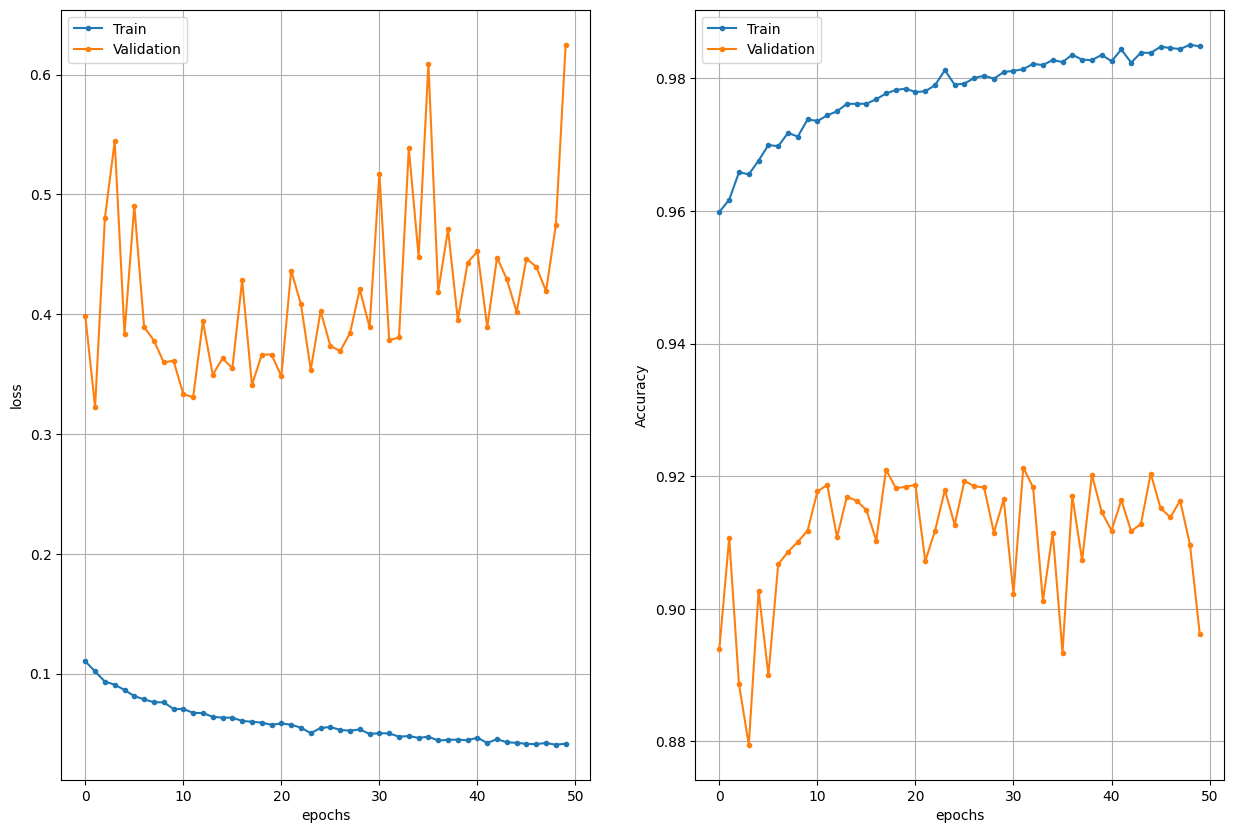

In [20]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])

def plot_histories(histories, labels):
    plt.figure(figsize=(12, 5))
    
    for i, (history, label) in enumerate(zip(histories, labels)):
        h = history.history
        epochs = range(len(h['loss']))
        
        plt.subplot(121)
        plt.plot(epochs, h['loss'], '.-', label=f'Train Loss-{label}')
        plt.plot(epochs, h['val_loss'], '.--', label=f'Val Loss-{label}')
        
        plt.subplot(122)
        plt.plot(epochs, h['accuracy'], '.-', label=f'Train Accuracy-{label}')
        plt.plot(epochs, h['val_accuracy'], '.--', label=f'Val Accuracy-{label}')

    plt.subplot(121)
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(122)
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    for history, label in zip(histories, labels):
        h = history.history
        print(f'Train Accuracy {label}:', h['accuracy'][-1])
        print(f'Validation Accuracy {label}:', h['val_accuracy'][-1])

plot_history(history)

As you can see, the classifier suffers from massive overfitting. The validation accuracy is around 88% while the training accuracy is close to 1.

### Combat the Overfitting!

Now it is your turn. Use the classifier as a baseline, include some regularization techniques and try to improve the classification performance. You can try any techniques you might see fit, e.g.,
* Dropout
* Batch normalization
* Weight regularization
* Data augmentation 
* Early stopping 
* Pooling
* Reducing the number of parameters (the size of the network)
* ...

There are to objective you shall fulfill in order to successfully complete this homework:
* The validation accuracy shall be above 91%
* Your network (with all the regularizations applied) shall **not** be larger than the baseline

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,213,002 (12.26 MB)

 Trainable params: 3,213,002 (12.26 MB)

 Non-trainable params: 0 (0.00 B)

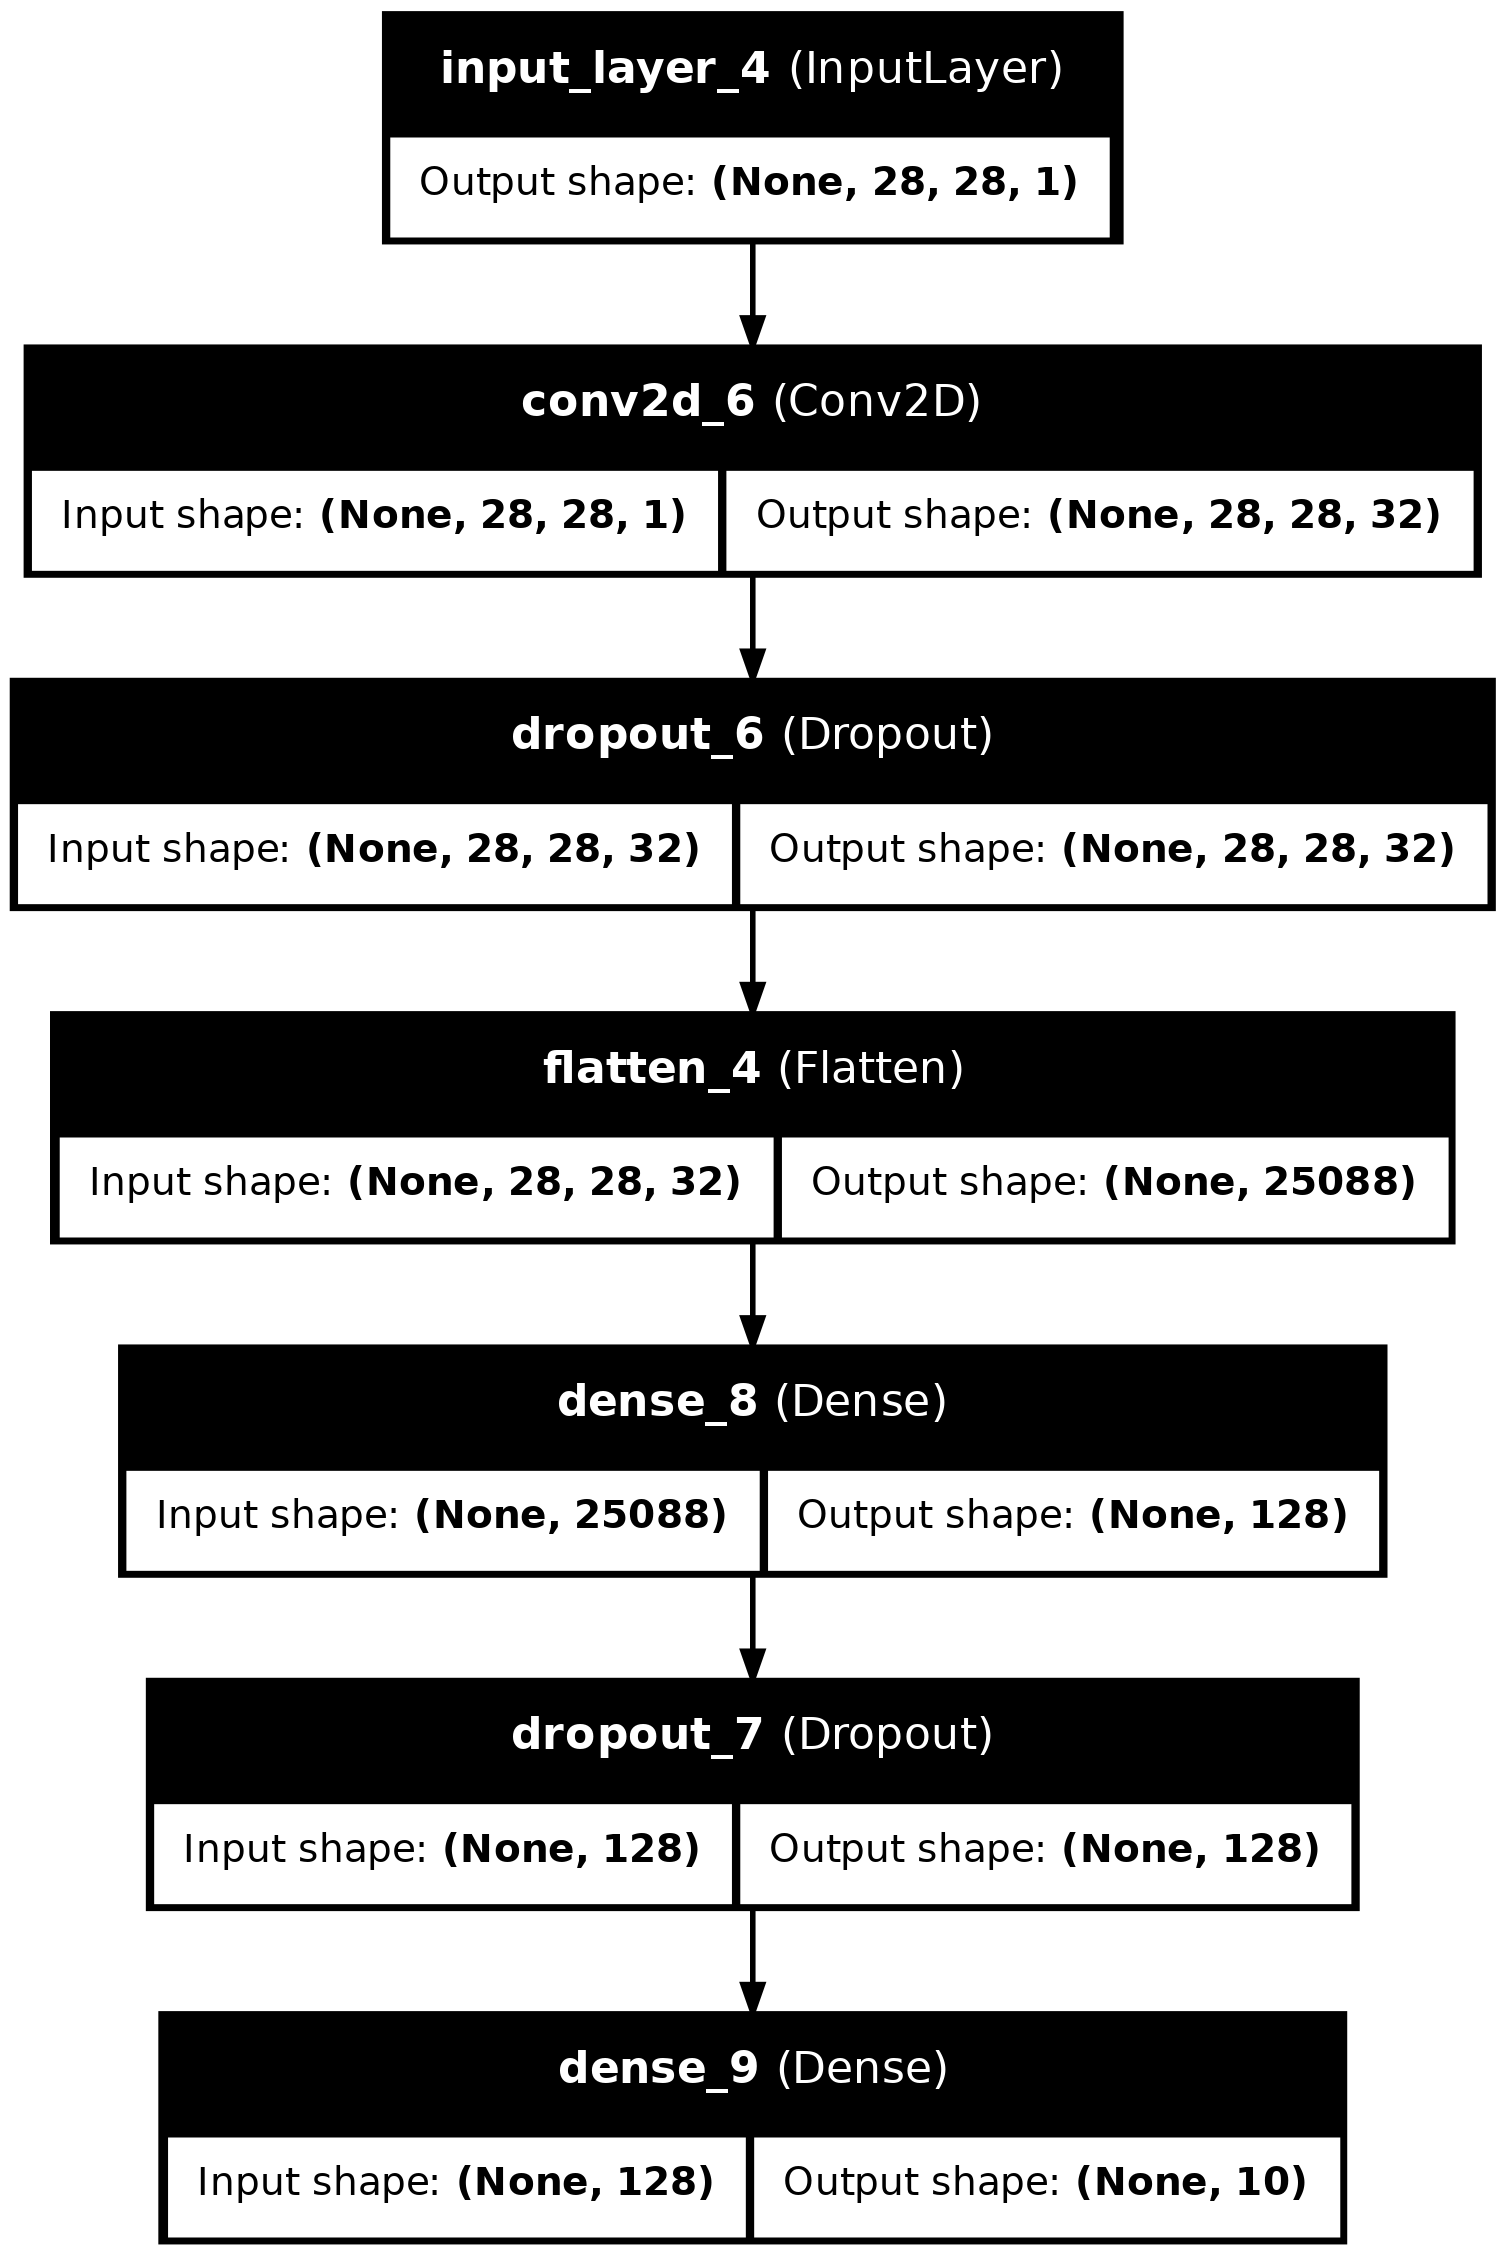

In [21]:
# Modify the baseline classifier in order to reduce the overfitting and make the performance more robust
model = create_model(
    Input(shape=(28, 28, 1)), 
    Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'), 
    Dropout(0.2), 
    Flatten(), 
    Dense(128), 
    Dropout(0.2),
    Dense(10, activation="softmax")
)
show_model(model)

In [22]:
history1 = fit_model(model)

Epoch 1/50
928/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8074 - loss: 0.5518

2024-07-29 12:30:31.494236: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1043', 24 bytes spill stores, 24 bytes spill loads

2024-07-29 12:30:31.566851: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1043', 36 bytes spill stores, 40 bytes spill loads

2024-07-29 12:30:31.579895: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1043', 24 bytes spill stores, 24 bytes spill loads



938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8079 - loss: 0.5503 - val_accuracy: 0.8772 - val_loss: 0.3463
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8899 - loss: 0.3087 - val_accuracy: 0.8854 - val_loss: 0.3217
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9042 - loss: 0.2649 - val_accuracy: 0.8916 - val_loss: 0.3133
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9153 - loss: 0.2325 - val_accuracy: 0.8863 - val_loss: 0.3267
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9224 - loss: 0.2136 - val_accuracy: 0.8889 - val_loss: 0.3279
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9280 - loss: 0.1939 - val_accuracy: 0.8899 - val_loss: 0.3411
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9340 - loss: 0.1771 - val_accuracy: 0.8909 - val_loss: 0.3509
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9382 - loss: 0.1652 - val_accuracy: 0.8868 - va

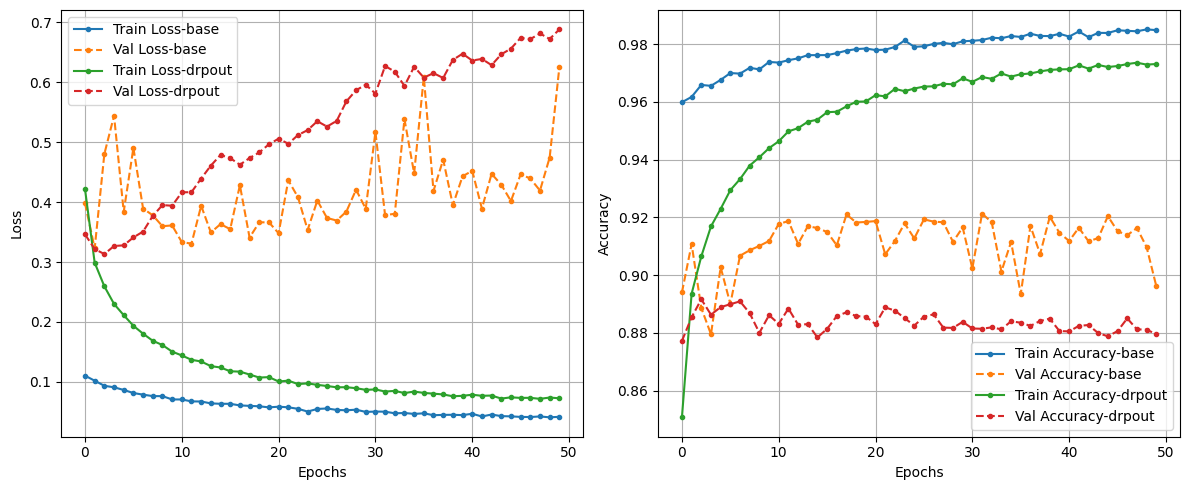

Train Accuracy base: 0.9848333597183228
Validation Accuracy base: 0.8962000012397766
Train Accuracy drpout: 0.9731000065803528
Validation Accuracy drpout: 0.8794999718666077


In [23]:

plot_histories([history,history1],["base","drpout"])


### Data Augmentation

In [24]:
from sklearn.utils import shuffle

def datagen(x, y, batch_size):
    num_samples = len(y)
    while True:
        for idx in range(0, num_samples, batch_size):
            x_ = x[idx:idx + batch_size, ...]
            y_ = y[idx:idx + batch_size]
            
            if len(y_) < batch_size:
                x, y = shuffle(x, y)
                break
            
            # Augmentation
            for idx_aug in range(batch_size):
                if np.random.rand() > 0.5:
                    x_[idx_aug, ...] = np.fliplr(x_[idx_aug, ...])                                
                    
            yield x_, y_

In [25]:
model = create_model(
    Input(shape=(28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    Flatten(),
    Dense(128),
    Dense(10, activation="softmax")
)

(60000, 28, 28)
Epoch 1/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8031 - loss: 0.5647 - val_accuracy: 0.8711 - val_loss: 0.3737
Epoch 2/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8905 - loss: 0.3078 - val_accuracy: 0.8793 - val_loss: 0.3392
Epoch 3/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9030 - loss: 0.2669 - val_accuracy: 0.8911 - val_loss: 0.3097
Epoch 4/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9126 - loss: 0.2430 - val_accuracy: 0.8907 - val_loss: 0.3063
Epoch 5/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9190 - loss: 0.2243 - val_accuracy: 0.8880 - val_loss: 0.3217
Epoch 6/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9244 - loss: 0.2106 - val_accuracy: 0.8951 - val_loss: 0.3080
Epoch 7/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9258 - loss: 0.2040 - val_accuracy: 0.8954 - val_loss: 0.3073
Epoch 8/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9321 - loss: 0.1879 - 

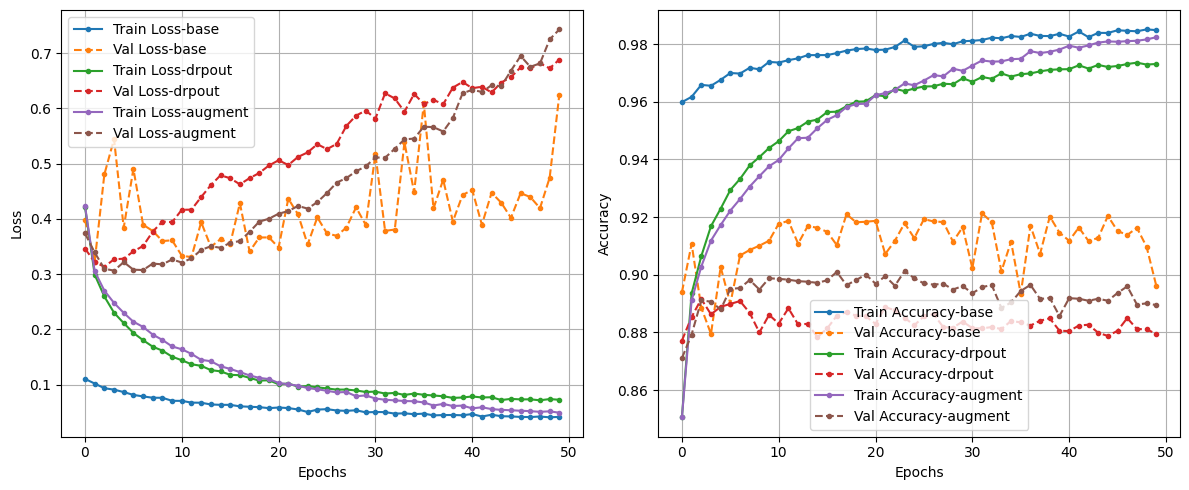

Train Accuracy base: 0.9848333597183228
Validation Accuracy base: 0.8962000012397766
Train Accuracy drpout: 0.9731000065803528
Validation Accuracy drpout: 0.8794999718666077
Train Accuracy augment: 0.9823739528656006
Validation Accuracy augment: 0.8895000219345093


In [26]:
epochs = 50
batch_size = 64
steps_per_epoch = len(y_train) // batch_size
generator = datagen(x_train, y_train, batch_size)
print(x_train.shape)

history2 = fit_model_generator(model,generator)
plot_histories([history, history1, history2],["base", "drpout", "augment"])

In [27]:
# Modify the baseline classifier in order to reduce the overfitting and make the performance more robust
model = create_model(
    Input(shape=(28, 28, 1)), 
    Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'), 
    Dropout(0.2), 
    Flatten(), 
    Dense(128), 
    Dropout(0.2),
    Dense(10, activation="softmax")
)

epochs = 50
batch_size = 64
steps_per_epoch = len(y_train) // batch_size
generator = datagen(x_train, y_train, batch_size)
print(x_train.shape)

history4 = fit_model_generator(model,generator)

(60000, 28, 28)
Epoch 1/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8053 - loss: 0.5510 - val_accuracy: 0.8748 - val_loss: 0.3613
Epoch 2/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8848 - loss: 0.3242 - val_accuracy: 0.8824 - val_loss: 0.3252
Epoch 3/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8988 - loss: 0.2819 - val_accuracy: 0.8922 - val_loss: 0.3045
Epoch 4/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9080 - loss: 0.2626 - val_accuracy: 0.8857 - val_loss: 0.3189
Epoch 5/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9104 - loss: 0.2491 - val_accuracy: 0.8946 - val_loss: 0.3030
Epoch 6/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9142 - loss: 0.2374 - val_accuracy: 0.8962 - val_loss: 0.2946
Epoch 7/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9181 - loss: 0.2243 - val_accuracy: 0.8957 - val_loss: 0.3043
Epoch 8/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9197 - loss: 0.2183 - 

Train Acc      0.9578441977500916
Validation Acc 0.8986999988555908


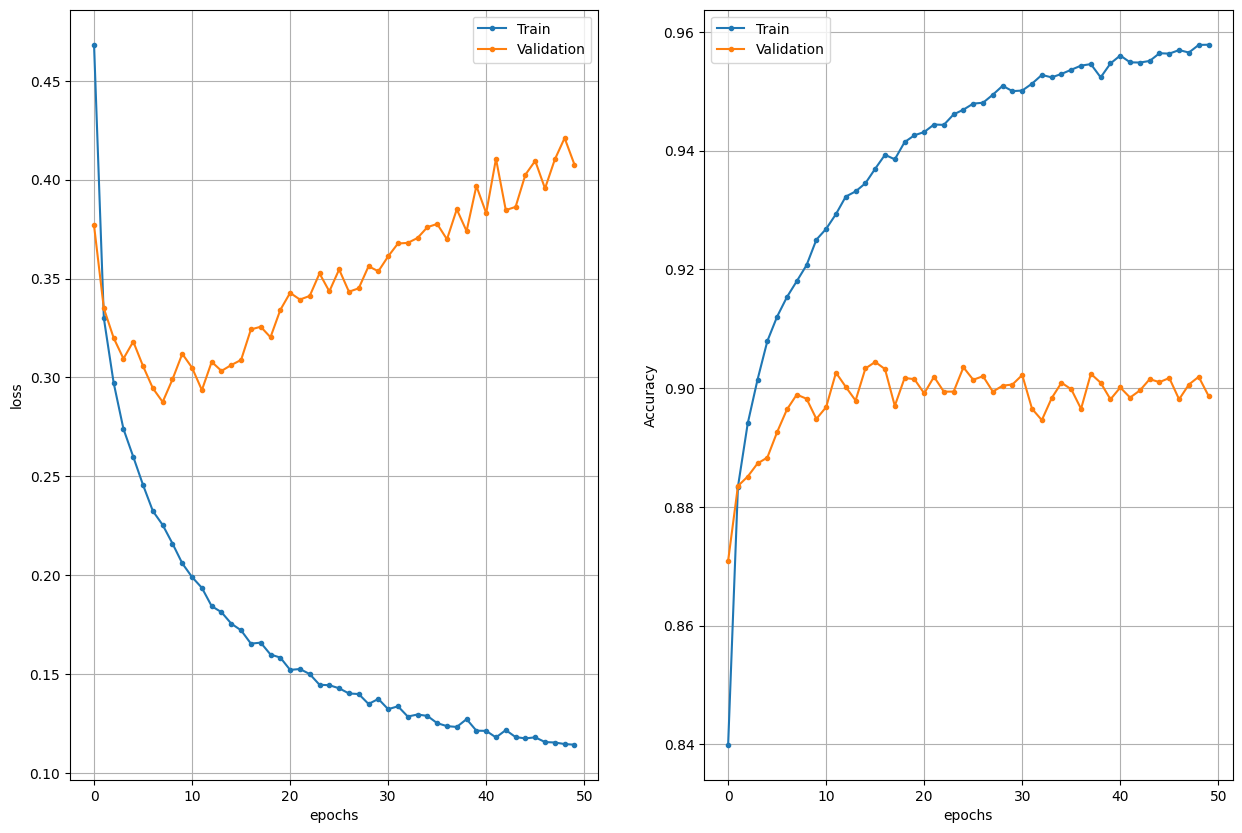

In [12]:
plot_history(history4)
# plot_histories([history, history1, history2, history4],["base", "drpout", "augment", "augPlusDrop"])

In [14]:
# Modify the baseline classifier in order to reduce the overfitting and make the performance more robust
model = create_model(
    Input(shape=(28, 28, 1)), 
    Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'), 
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'), 
    Dropout(0.2),     
    Flatten(), 
    Dense(128), 
    Dropout(0.2),
    Dense(10, activation="softmax")
)

epochs = 50
batch_size = 64
steps_per_epoch = len(y_train) // batch_size
generator = datagen(x_train, y_train, batch_size)
print(x_train.shape)

history5 = fit_model_generator(model,generator)

(60000, 28, 28)
Epoch 1/50


2024-07-29 12:08:13.000628: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1131', 164 bytes spill stores, 164 bytes spill loads

2024-07-29 12:08:13.165509: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1131', 440 bytes spill stores, 440 bytes spill loads



937/937 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7855 - loss: 0.5989 - val_accuracy: 0.8684 - val_loss: 0.3678
Epoch 2/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8836 - loss: 0.3234 - val_accuracy: 0.8985 - val_loss: 0.2918
Epoch 3/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9045 - loss: 0.2704 - val_accuracy: 0.9033 - val_loss: 0.2642
Epoch 4/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9127 - loss: 0.2459 - val_accuracy: 0.9091 - val_loss: 0.2548
Epoch 5/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9158 - loss: 0.2336 - val_accuracy: 0.9150 - val_loss: 0.2398
Epoch 6/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9204 - loss: 0.2181 - val_accuracy: 0.9026 - val_loss: 0.2649
Epoch 7/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9245 - loss: 0.2082 - val_accuracy: 0.9154 - val_loss: 0.2492
Epoch 8/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9268 - loss: 0.2020 - val_accuracy: 0.9125 - val

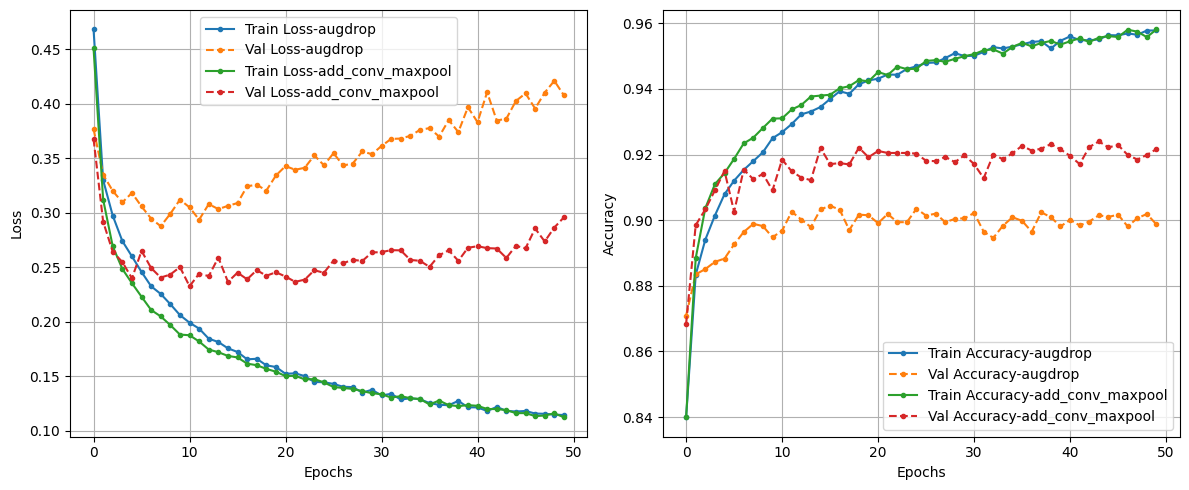

Train Accuracy augdrop: 0.9578441977500916
Validation Accuracy augdrop: 0.8986999988555908
Train Accuracy add_conv_maxpool: 0.9581609964370728
Validation Accuracy add_conv_maxpool: 0.9217000007629395


In [16]:
plot_histories([history4,history5],["augdrop","add_conv_maxpool"])

In [17]:
# Modify the baseline classifier in order to reduce the overfitting and make the performance more robust
model = create_model(
    Input(shape=(28, 28, 1)), 
    Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'), 
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'), 
    BatchNormalization(),
    Dropout(0.2),     
    Flatten(), 
    Dense(128), 
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation="softmax")
)

epochs = 50
batch_size = 64
steps_per_epoch = len(y_train) // batch_size
generator = datagen(x_train, y_train, batch_size)
print(x_train.shape)

history6 = fit_model_generator(model,generator)

(60000, 28, 28)
Epoch 1/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8176 - loss: 0.5354 - val_accuracy: 0.8629 - val_loss: 0.3892
Epoch 2/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8957 - loss: 0.2937 - val_accuracy: 0.8976 - val_loss: 0.3050
Epoch 3/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9077 - loss: 0.2616 - val_accuracy: 0.8855 - val_loss: 0.3182
Epoch 4/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9133 - loss: 0.2383 - val_accuracy: 0.8831 - val_loss: 0.3113
Epoch 5/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9186 - loss: 0.2274 - val_accuracy: 0.9075 - val_loss: 0.2611
Epoch 6/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9231 - loss: 0.2117 - val_accuracy: 0.9104 - val_loss: 0.2478
Epoch 7/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9243 - loss: 0.2059 - val_accuracy: 0.9079 - val_loss: 0.2613
Epoch 8/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9276 - loss: 0.1990 -

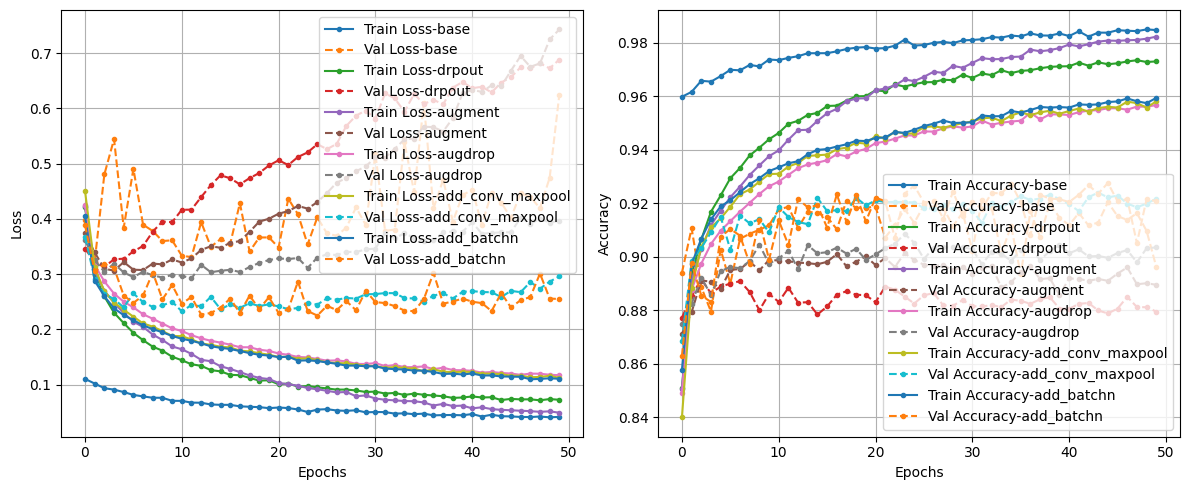

Train Accuracy base: 0.9848333597183228
Validation Accuracy base: 0.8962000012397766
Train Accuracy drpout: 0.9731000065803528
Validation Accuracy drpout: 0.8794999718666077
Train Accuracy augment: 0.9823739528656006
Validation Accuracy augment: 0.8895000219345093
Train Accuracy augdrop: 0.9567602872848511
Validation Accuracy augdrop: 0.9035000205039978
Train Accuracy add_conv_maxpool: 0.9581609964370728
Validation Accuracy add_conv_maxpool: 0.9217000007629395
Train Accuracy add_batchn: 0.959445059299469
Validation Accuracy add_batchn: 0.920799970626831


In [28]:
plot_histories([history, history1, history2, history4, history5, history6],["base", "drpout", "augment", "augdrop","add_conv_maxpool","add_batchn"])

In [30]:
model = create_model(
    Input(shape=(28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    BatchNormalization(),
    Flatten(),
    Dense(128),
    Dense(10, activation="softmax")
)

epochs = 50
batch_size = 64
steps_per_epoch = len(y_train) // batch_size
generator = datagen(x_train, y_train, batch_size)
print(x_train.shape)

history7 = fit_model_generator(model,generator)

(60000, 28, 28)
Epoch 1/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7977 - loss: 1.5190 - val_accuracy: 0.8624 - val_loss: 0.3963
Epoch 2/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8930 - loss: 0.3076 - val_accuracy: 0.8832 - val_loss: 0.3446
Epoch 3/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9080 - loss: 0.2593 - val_accuracy: 0.8789 - val_loss: 0.3570
Epoch 4/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9145 - loss: 0.2393 - val_accuracy: 0.8783 - val_loss: 0.3525
Epoch 5/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9176 - loss: 0.2298 - val_accuracy: 0.8760 - val_loss: 0.3745
Epoch 6/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9244 - loss: 0.2092 - val_accuracy: 0.8776 - val_loss: 0.3716
Epoch 7/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9270 - loss: 0.2028 - val_accuracy: 0.8867 - val_loss: 0.3498
Epoch 8/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9304 - loss: 0.1913 - 

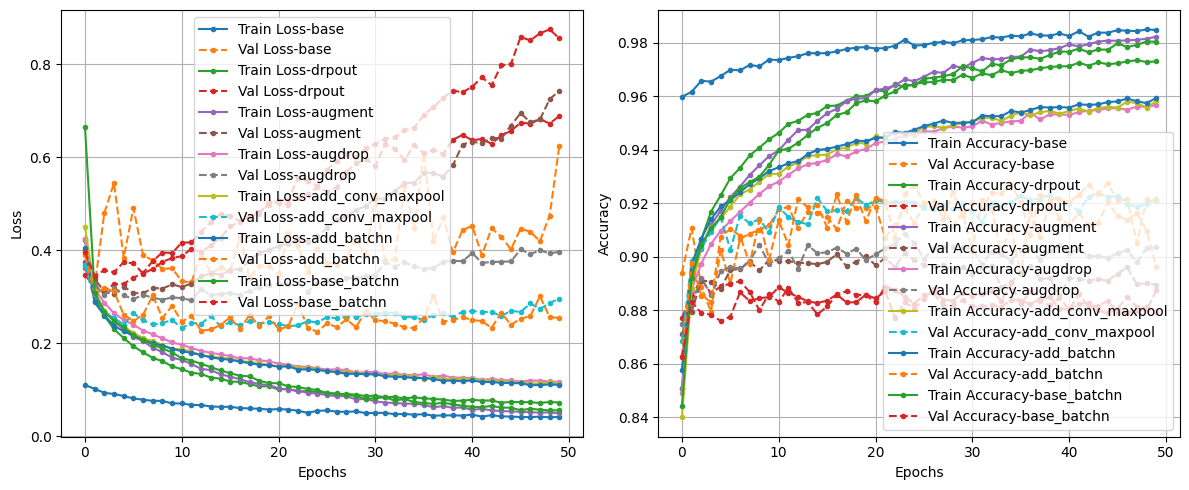

Train Accuracy base: 0.9848333597183228
Validation Accuracy base: 0.8962000012397766
Train Accuracy drpout: 0.9731000065803528
Validation Accuracy drpout: 0.8794999718666077
Train Accuracy augment: 0.9823739528656006
Validation Accuracy augment: 0.8895000219345093
Train Accuracy augdrop: 0.9567602872848511
Validation Accuracy augdrop: 0.9035000205039978
Train Accuracy add_conv_maxpool: 0.9581609964370728
Validation Accuracy add_conv_maxpool: 0.9217000007629395
Train Accuracy add_batchn: 0.959445059299469
Validation Accuracy add_batchn: 0.920799970626831
Train Accuracy base_batchn: 0.9804896116256714
Validation Accuracy base_batchn: 0.8873999714851379


In [31]:
plot_histories(
    [history, history1, history2, history4, history5, history6, history7],
    ["base", "drpout", "augment", "augdrop","add_conv_maxpool","add_batchn","base_batchn"])

Train Acc      0.9804896116256714
Validation Acc 0.8873999714851379


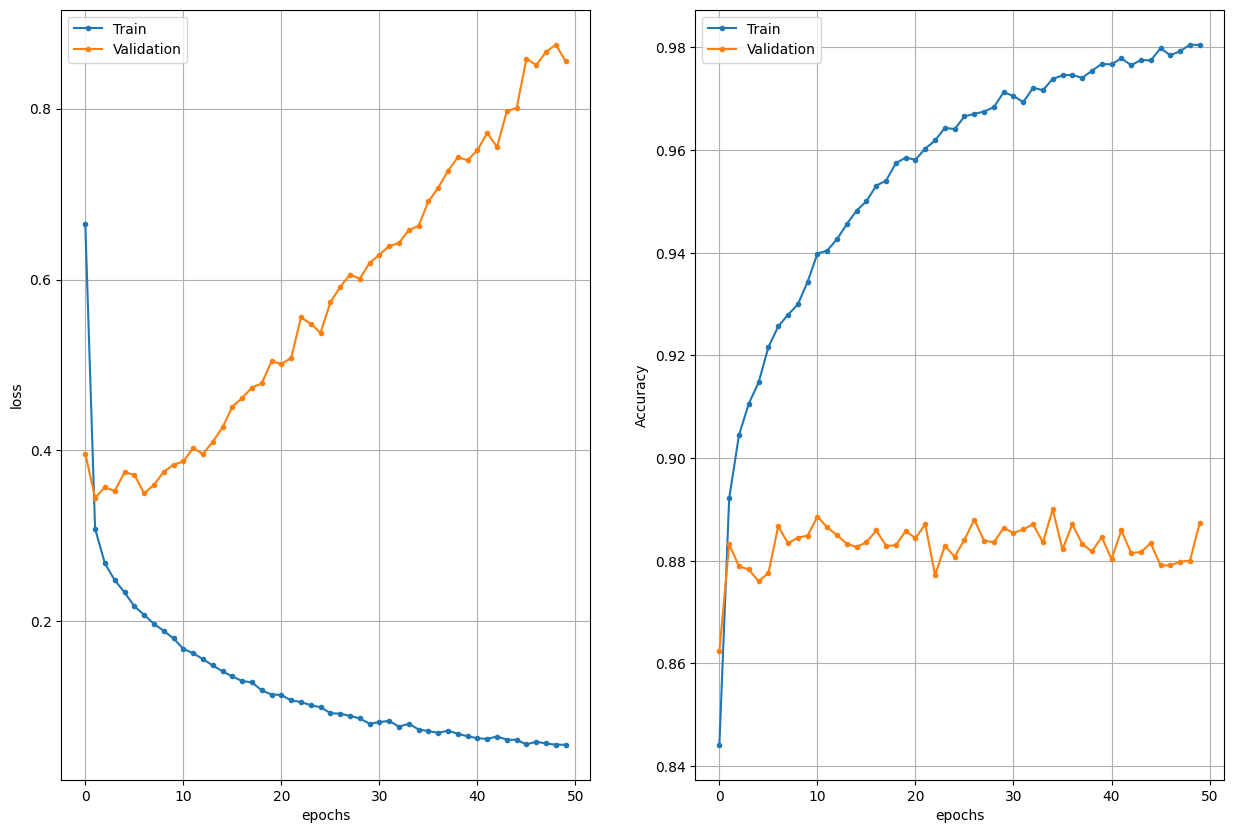

In [32]:
plot_history(history7)

(60000, 28, 28)
Epoch 1/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7822 - loss: 1.1658 - val_accuracy: 0.8590 - val_loss: 0.3977
Epoch 2/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8758 - loss: 0.3499 - val_accuracy: 0.8677 - val_loss: 0.3725
Epoch 3/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8919 - loss: 0.3019 - val_accuracy: 0.8845 - val_loss: 0.3388
Epoch 4/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8974 - loss: 0.2850 - val_accuracy: 0.8819 - val_loss: 0.3321
Epoch 5/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8970 - loss: 0.2824 - val_accuracy: 0.8855 - val_loss: 0.3385
Epoch 6/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9042 - loss: 0.2618 - val_accuracy: 0.8843 - val_loss: 0.3382
Epoch 7/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9046 - loss: 0.2575 - val_accuracy: 0.8898 - val_loss: 0.3258
Epoch 8/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9118 - loss: 0.2402 - 

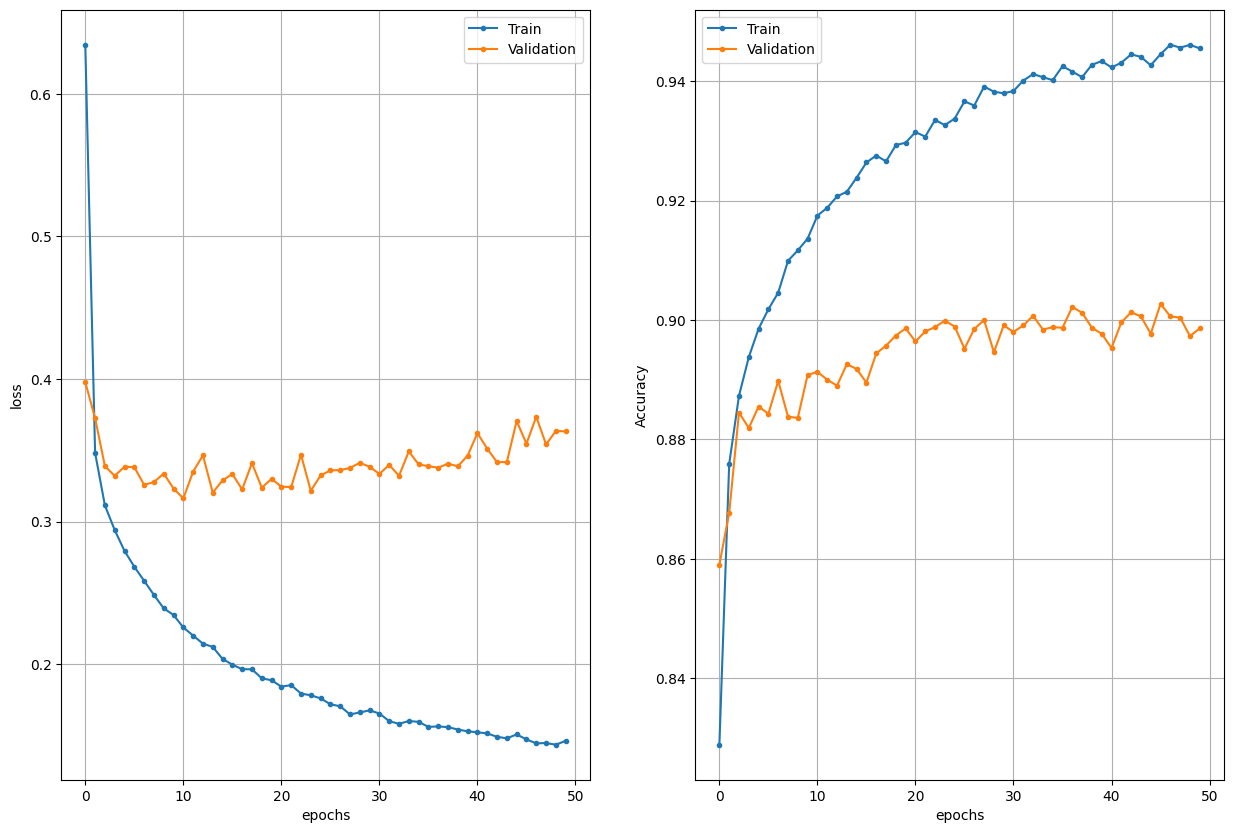

In [37]:
model = create_model(
    Input(shape=(28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    Dropout(0.2),
    BatchNormalization(),
    Flatten(),
    Dropout(0.2),
    Dense(128),
    Dense(10, activation="softmax")
)

epochs = 50
batch_size = 64
steps_per_epoch = len(y_train) // batch_size
generator = datagen(x_train, y_train, batch_size)
print(x_train.shape)

history8_base_aug_dropout_batchnorm = fit_model_generator(model,generator)

plot_history(history8_base_aug_dropout_batchnorm)

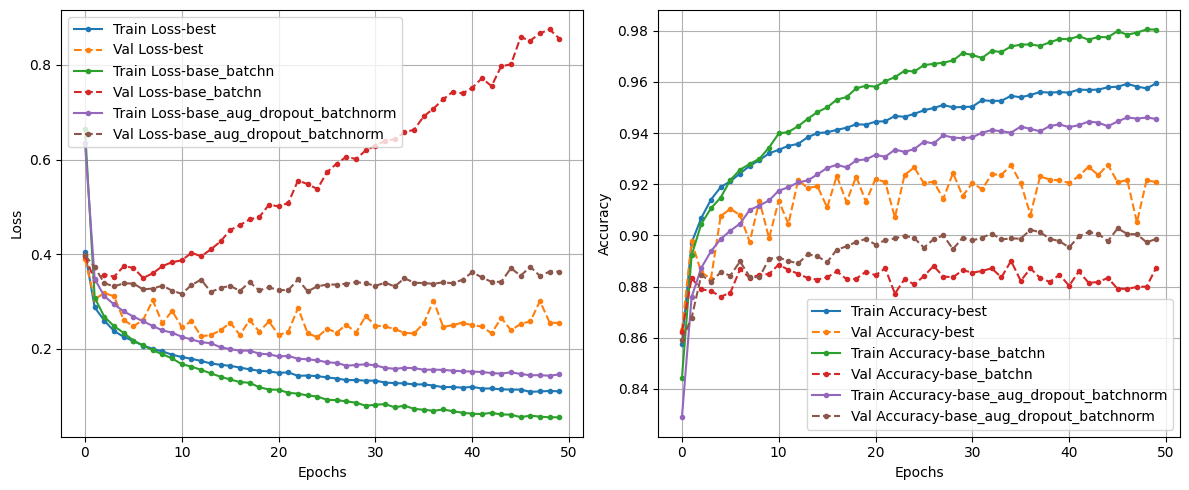

Train Accuracy best: 0.959445059299469
Validation Accuracy best: 0.920799970626831
Train Accuracy base_batchn: 0.9804896116256714
Validation Accuracy base_batchn: 0.8873999714851379
Train Accuracy base_aug_dropout_batchnorm: 0.9455209374427795
Validation Accuracy base_aug_dropout_batchnorm: 0.8985999822616577


In [41]:
plot_histories(
    [history6,history7,history8_base_aug_dropout_batchnorm],
    ["best","base_batchn","base_aug_dropout_batchnorm"])

(60000, 28, 28)
Epoch 1/50


2024-07-29 13:26:25.341641: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1832', 164 bytes spill stores, 164 bytes spill loads

2024-07-29 13:26:26.194684: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1832', 432 bytes spill stores, 432 bytes spill loads



937/937 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8029 - loss: 0.5801 - val_accuracy: 0.8630 - val_loss: 0.3821
Epoch 2/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8787 - loss: 0.3408 - val_accuracy: 0.8843 - val_loss: 0.3228
Epoch 3/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8886 - loss: 0.3098 - val_accuracy: 0.8861 - val_loss: 0.3227
Epoch 4/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8956 - loss: 0.2858 - val_accuracy: 0.8918 - val_loss: 0.3053
Epoch 5/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8981 - loss: 0.2789 - val_accuracy: 0.8943 - val_loss: 0.2987
Epoch 6/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9031 - loss: 0.2654 - val_accuracy: 0.8958 - val_loss: 0.2963
Epoch 7/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9078 - loss: 0.2559 - val_accuracy: 0.8971 - val_loss: 0.2957
Epoch 8/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9124 - loss: 0.2460 - val_accuracy: 0.9004 - val

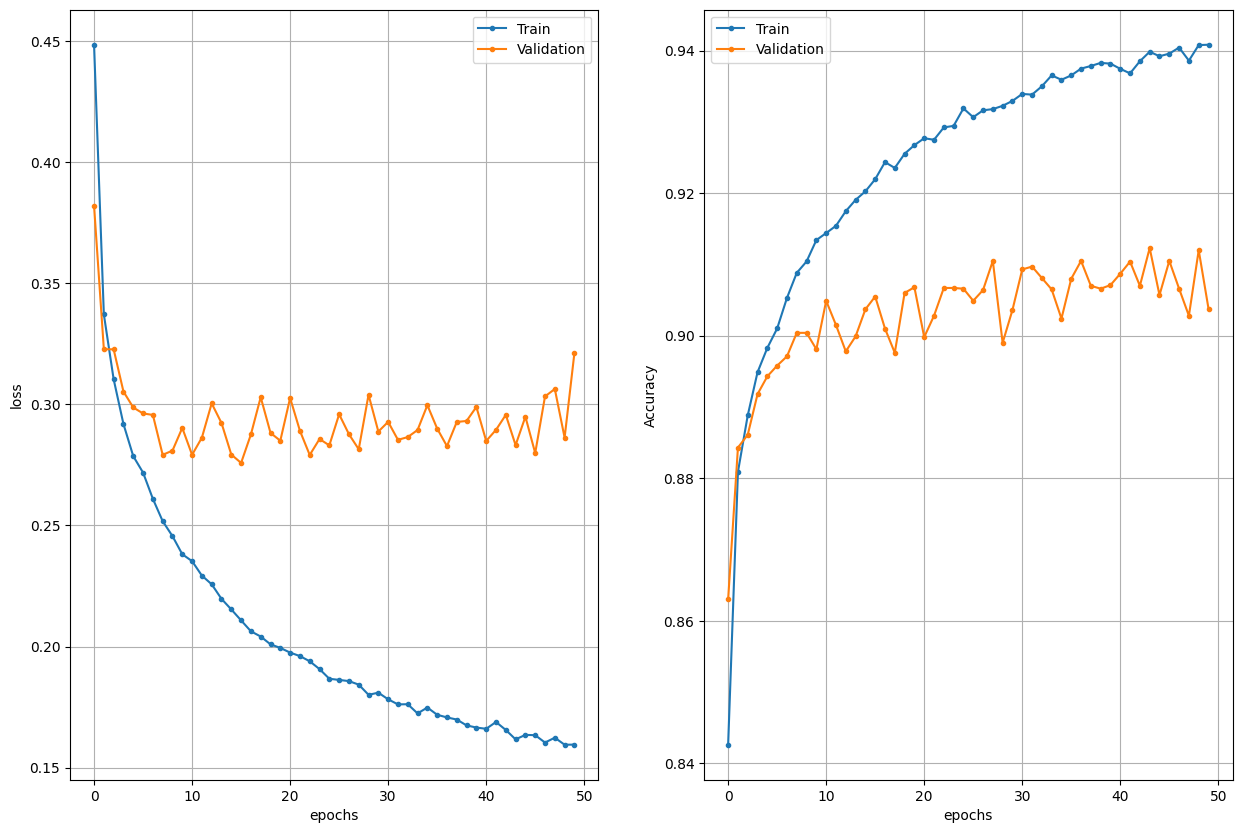

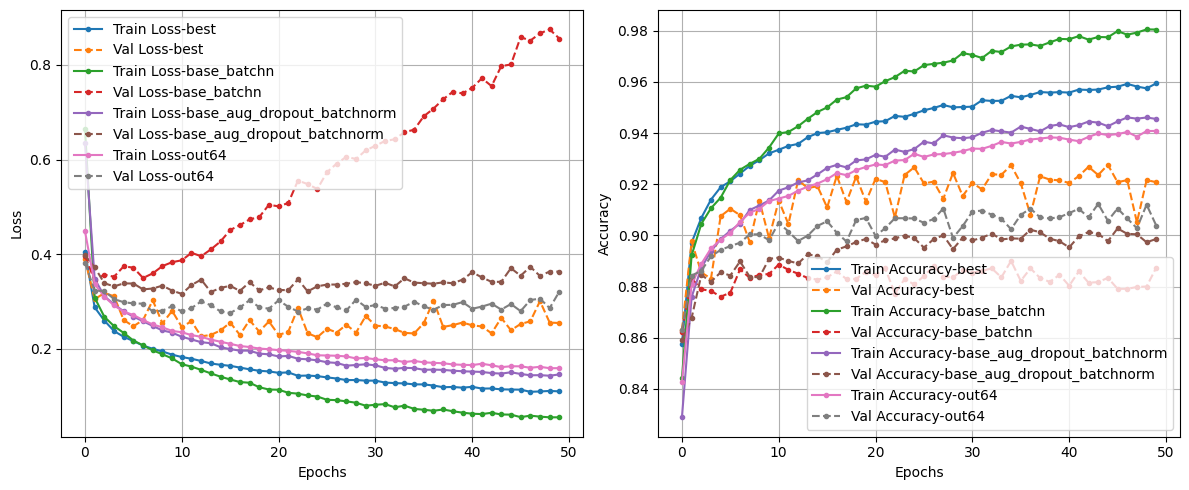

Train Accuracy best: 0.959445059299469
Validation Accuracy best: 0.920799970626831
Train Accuracy base_batchn: 0.9804896116256714
Validation Accuracy base_batchn: 0.8873999714851379
Train Accuracy base_aug_dropout_batchnorm: 0.9455209374427795
Validation Accuracy base_aug_dropout_batchnorm: 0.8985999822616577
Train Accuracy out64: 0.9408351182937622
Validation Accuracy out64: 0.9038000106811523


In [42]:
model = create_model(
    Input(shape=(28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
    Dropout(0.2),
    BatchNormalization(),
    Flatten(),
    Dropout(0.2),
    Dense(128),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64),
    Dense(10, activation="softmax")
)

epochs = 50
batch_size = 64
steps_per_epoch = len(y_train) // batch_size
generator = datagen(x_train, y_train, batch_size)
print(x_train.shape)

history9_base_aug_dropout_batchnorm_128_64 = fit_model_generator(model,generator)

plot_history(history9_base_aug_dropout_batchnorm_128_64)

plot_histories(
    [history6,history7,history8_base_aug_dropout_batchnorm, history9_base_aug_dropout_batchnorm_128_64],
    ["best","base_batchn","base_aug_dropout_batchnorm", "out64"])

### Questions

* What have you done in order to improve the performance?

  I do all.
    Dropout
    Batch normalization
    Weight regularization
    Data augmentation
    Early stopping
    Pooling
    Reducing the number of parameters (the size of the network).The best was
        Input(shape=(28, 28, 1)), 
        Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'), 
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'), 
        Dropout(0.2),     
        Flatten(), 
        Dense(128), 
        Dropout(0.2),
        Dense(10, activation="softmax
    But for improve the result of validation test i add one conlulution layer.
* Have you tried configurations that did not work out? Yes BatchNormalization didn't help in the some situations.